In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import UnivariateSpline,interp1d 
from os import listdir,path,walk
import matplotlib as mpl
from scipy.signal import savgol_filter
import lmfit as lm
import scipy.stats as stats
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import date

mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.linewidth'] = 1.5
pd.options.display.float_format = '{:,.4f}'.format
colors = {"Sec2_GFP":"brown","WT":"b","Sec9_GFP":"orange","Sec18_AA":"purple"}


# SMLM Classification / Copy number / Averaging

In [56]:
#---Simulation dataset----
#------File containing the geometrical features for the synthetic sites
geom_params  = pd.read_csv("/home/jsortiz/phd/Beta-Fitting/Geom_params_data_Simulate_Rings_Nfold_Rv_15_50_Nexos_6_8_ForPaper.csv")
#------File containing the localization coordinates for each synthetic sites
simul_params = pd.read_csv("/home/jsortiz/phd/Beta-Fitting/All_data_Simulate_Rings_Nfold_Rv_15_50_Nexos_6_8_ForPaper.csv")
#-------------------------

#---Experimetan dataset----
#------File containing the geometrical features for the experimental sites
#------Datasets: Exo-mM-GFP, Exo-mM/Sec2-GFP, Exo-mM/Sec9-GFP, Exo-mM-GFP (Sec18_AA)
exp_params = pd.read_csv("/home/jsortiz/phd/Beta-Fitting/Feature_Experimental_Dataset_Classified.csv")
#-------------------------

##  Fig S4: Comparing Rg with Spots and Rings

'fig = plt.figure()\nb = sns.color_palette("Greys",5,as_cmap=False)\nsns.heatmap([[0,0],[1,1]],cmap=b)\n#plt.colorbar()\nplt.savefig("figs/color_bar.svg")\n'

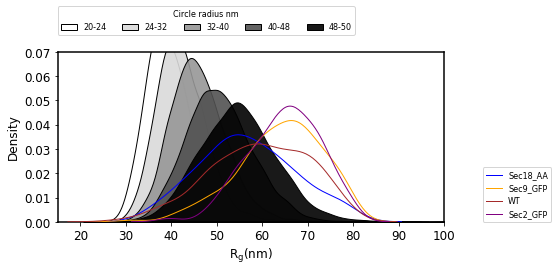

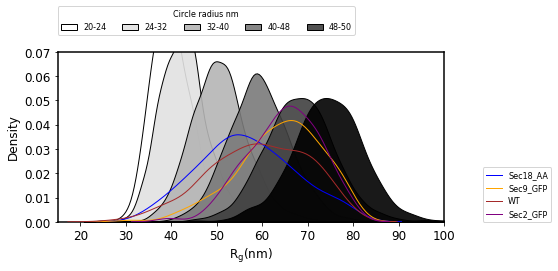

In [8]:
sets= ["Sec2_GFP","WT","Sec9_GFP","Sec18_AA"]

sets_names = {"WT": "Exocyst-mM-GFP",
              "Sec2_GFP": "Exocyst-mM/Sec2-GFP",
              "Sec9_GFP": "Exocyst-mM/Sec9-GFP",
              "Sec18_AA": "Exocyst-mM-GFP/Sec18-FRB"}

for idM in ["Spot","Ring"]:
    
    if idM == "Ring":        
        geom_params = pd.read_csv("Geom_params_data_Simulate_Rings_Nfold_Rv_15_50_Nexos_6_8_ForPaper.csv")
    elif idM == "Spot":
        geom_params = pd.read_csv("Geom_params_data_Simulate_Spots_Rv_8_50_Nexos_6_8_ForPaper.csv") 
    else:
        break                   
                                  
    geom_params = geom_params.query("Rv>15").copy()
    
    plt.figure(figsize=(8,4))

    geom_params["Model"] = geom_params["Rv"]//8
    
    sns.kdeplot(data=geom_params,x="R_2nd",hue=-geom_params["Model"],
                common_norm=False,fill=True,alpha=.9,palette='Greys_r',lw=1.,cbar=True,edgecolor='k')  
    
    plt.legend(["20-24","24-32", "32-40","40-48", "48-50"],
        loc=[.0,1.1],title="Circle radius nm",ncol=5,fontsize=8,title_fontsize=8)
    plt.xlim(15,100)
    plt.ylim(0,0.07)
    plt.xlabel("$\mathrm{R_g (nm)}$")

    ax2 = plt.twinx()  
    sns.kdeplot(data=exp_params,hue="Set",x="R_2nd",common_norm=False,palette=colors,lw=1.,ax=ax2)
    
    ax2.set_xlim(15,100)
    ax2.set_ylim(0,0.07)
    ax2.legend(np.flip(sets),loc=[1.1,0],fontsize=8)    
    ax2.set_axis_off()    
    
    
    plt.tight_layout()

    
    #plt.savefig("figs/Paper_Figures/Comparing_%s_WT.png"%idM,dpi=80,facecolor='white')

"""fig = plt.figure()
b = sns.color_palette("Greys",5,as_cmap=False)
sns.heatmap([[0,0],[1,1]],cmap=b)
#plt.colorbar()
plt.savefig("figs/color_bar.svg")
"""

In [ ]:
plt.plot(d)

## SMLM Copy number

### Functions

In [103]:
def errn_stan(x_tar,x_ref,nref):    
    
    x  = np.mean(x_tar)    
    y  = np.mean(x_ref)    
    
    nx = len(x_tar)
    ny = len(x_ref)
    
    sx = np.std(x_tar)     
    sy = np.std(x_ref)     
    
    n    = x/y*nref
    sn   = n*np.sqrt(sx**2/x**2+sy**2/y**2)
    
    return(n,sn)

def denplot(locs,xshift,ax=plt,style=1,**kwargs):    
    #+++++++++++++++Log-normal kernel++++++++++++++++++++++++++++            
    fit = stats.lognorm.fit(locs,floc=0)    
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++     
    xs  = np.arange(locs.min()-2,locs.max()+2)
    y   = stats.lognorm.pdf(xs,fit[0],loc=0,scale=fit[2])
    norm= np.max(y)/0.45
    y   = y/norm   
    #plt.plot(xshift+y,xs,color='gray',lw=1)
    #plt.plot(xshift-y,xs,color='gray',lw=1)
    ax.fill_betweenx(xs,xshift-y,xshift+y,**kwargs)       
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++            
    y   = stats.lognorm.pdf(locs,fit[0],loc=0,scale=fit[2])
    y   = y/norm
    xrand  = np.random.uniform(-y,y)
    if style == 1:
        ax.scatter(xshift+xrand,locs,color='w',edgecolors='k',linewidths=1,s=20,alpha=0.5)            
    else:
        ax.scatter(xshift+xrand,locs,color='w',edgecolors='r',linewidths=1,s=20,alpha=0.5)                          
    #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++                               

    
def makeplot(params_file,sets,ax=plt):     
    preds  = ["Compact","Expanded"]
    for i,ids in enumerate(sets):
        for j,idm in enumerate(preds):    
            data = params_file.query("Pred == '%s' and Set == '%s'"%(idm,ids))[["Nt_Locs_Gr","File_ID"]].copy()             
            #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
            locs = data["Nt_Locs_Gr"].copy()
            print(len(data))
            denplot(locs,xshift=(2.5*i+ j%2),ax=ax,color='1.' if idm=='Compact' else ".8",
                    label= idm if i == 0 else None,edgecolors='gray')
            #++++++++++++++++++++++++++++++++++++++++++++++++
            mean = data.groupby("File_ID").mean().values
            lent = data.groupby("File_ID").count().values
            std  = data.groupby("File_ID").std(ddof=1).values

            mean = np.nansum(lent*mean)/np.sum(lent)      # Pooled Mean
            wi   = (lent-1)/(np.nansum(lent)-lent)# Pooled weights
            sd   = np.sqrt(np.nansum(std**2*wi))  # Pooled SD
            sem  = sd/np.sqrt(np.sum(lent))    # Pooled SEM            
            #++++++++++++++++++++++++++++++++++++++++++++++++
            ax.bxp([dict({
                    "med"   : mean,
                    "q1"    : mean-sem,
                    "q3"    : mean+sem,
                    "whislo": mean-sd,
                    "whishi": mean+sd})],
                  positions=[(2.5*i+ j%2)],showfliers=False,patch_artist=False,
                   medianprops={"color":'.0','lw':2},
                   whiskerprops={"lw":2},
                   zorder=20+j,widths=.4)

### Run

In [82]:
locs_npc_4 = np.loadtxt("NLocs_ExpSets/locs_NPC_dataset_4.dat")[:,0]
locs_npc_3 = np.loadtxt("NLocs_ExpSets/locs_NPC_dataset_3.dat")[:,0]
locs_npc_2 = np.loadtxt("NLocs_ExpSets/locs_NPC_dataset_2.dat")[:,0]

41
95


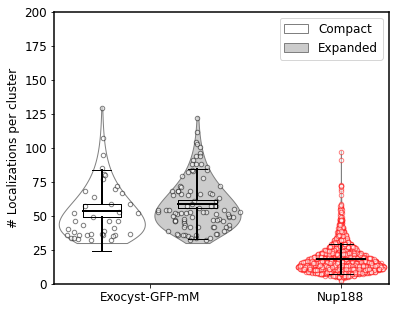

In [117]:
#print("%10s \tDistal %16s %15s %12s"%("Set","N","Proximal","N"))
fig,ax = plt.subplots(1,1,figsize=(2*3,5))
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
makeplot(exp_params,["WT"],ax=ax)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

y = locs_npc_2.copy()
denplot(y,xshift=(2.*(0+1)+.5),style=2,color='w',edgecolors='gray')

ax.bxp([dict({"med":y.mean(),
        "q1" :y.mean()-y.mean()/np.sqrt(len(y)),
        "q3" :y.mean()+y.mean()/np.sqrt(len(y)),
        "whislo": y.mean()-y.std(),
        "whishi" : y.mean()+y.std()})],
      positions=[(2.*(0+1)+.5)],showfliers=False, patch_artist=False,
    medianprops={"color":'.0','lw':2},widths=.5,zorder=3,whiskerprops={"lw":2})


ax.set_xticks(np.arange(.5,3.5*(0+1),2))
ax.set_ylim(0,200)
ax.set_xticklabels(["Exocyst-GFP-mM","Nup188"])
ax.set_ylabel("# Localizations per cluster")
ax.legend()
#plt.savefig("figs/Copy_Number_WT.svg")

44
129
16
186
13
207


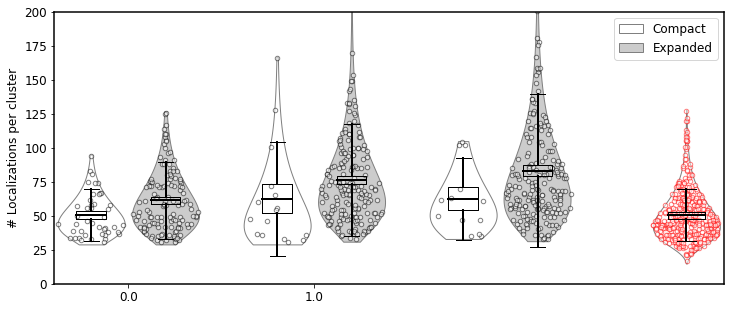

In [120]:
#print("%10s \tDistal %16s %15s %12s"%("Set","N","Proximal","N"))
fig,ax = plt.subplots(1,1,figsize=(4*3,5))
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
makeplot(exp_params,["Sec2_GFP","Sec9_GFP","Sec18_AA"],ax=ax)
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


y = locs_npc_3.copy()

denplot(y,xshift=(2.5*(2+1)+.5),style=2,color='w',edgecolors='gray')

ax.bxp([dict({"med":y.mean(),
        "q1" :y.mean()-y.mean()/np.sqrt(len(y)),
        "q3" :y.mean()+y.mean()/np.sqrt(len(y)),
        "whislo": y.mean()-y.std(),
        "whishi" : y.mean()+y.std()})],
      positions=[(2.5*(2+1)+.5)],showfliers=False, patch_artist=False,
    medianprops={"color":'.0','lw':2},widths=.5,zorder=3,whiskerprops={"lw":2})

ax.set_xticks([0.5, 3.0])
#ax.set_xticks([0.5,1])
#ax.set_xticklabels(["Exocyst-mM/\nSec2-GFP","Exocyst-mM/\nSec9-GFP","Exocyst-mM-GFP\/nSec18_AA","Nup188"])
ax.set_ylabel("# Localizations per cluster")
ax.set_ylim(0,200)
ax.legend()
#plt.savefig("figs/Copy_Number_Others.svg")

In [114]:
list(np.arange(.5,3.5*(2+1),2.5))

[0.5, 3.0, 5.5, 8.0]

In [110]:
ax.show()

AttributeError: 'AxesSubplot' object has no attribute 'show'